In [1]:
# siamese network described here
# https://www.coursera.org/learn/custom-models-layers-loss-functions-with-tensorflow/lecture/HUkok/siamese-network-code-walkthrough
# another student write up example https://github.com/ANKITPODDER2000/Tensorflow-Advance/blob/main/Custom_Models_Layers_and_Loss_Functions_with_TensorFlow/Week1/siamese_network.ipynb

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Lambda
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import random
import matplotlib.pyplot as plt
import pdb

use_debugger = False

In [3]:
## This block makes the dataset in pairs which the siamese network needs
## if the items have the same label it will make them into a positive pair
## otherwise it will be a negative pair


def create_pairs(images, digit_indices):
    ''' Positive and negative pair creation, alternates between positive and negative.
    Positive means the two images in the pair are similar to each other (example both are t-shirts)
    Negative means that the two images in the pair are different (example shoe and shirt)'''
    
    pairs = []
    labels = []
    n = [len(digit_indices[d]) for d in range(10)]
    n = min(n) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [ [images[z1] , images[z2]] ]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs +=[[images[z1], images[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0


train_pairs , train_labels = create_pairs_on_set(train_images , train_labels)
test_pairs  , test_labels  = create_pairs_on_set(test_images  , test_labels )

In [5]:
def show_pair_images(img_ind, images=train_pairs, label=train_labels):
    _, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].imshow(images[img_ind][0])
    ax[1].imshow(images[img_ind][1])
    print("are they the same? ", bool(train_labels[img_ind]))

are they the same?  False


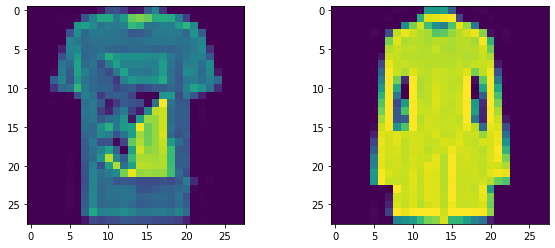

In [6]:
show_pair_images(101)
# dataset is made so that odd is not same 

are they the same?  True


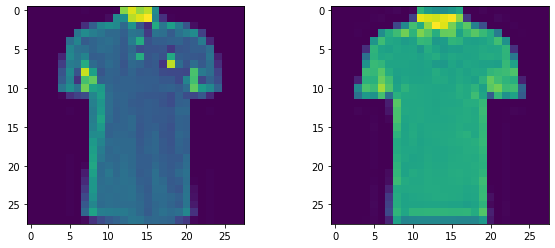

In [7]:
show_pair_images(50)
# even is made so that imgs are the same

In [8]:
def euclidean_distance(vects):
    '''distance formula between the two vectors, in this case
    each image in the pair will give us a dense output of 128 and we will 
    compute the distance between the two dense weights
    vects is a list of 2 elements that looks like this 
    [<tf.Tensor 'Placeholder:0' shape=(None, 128) dtype=float32>,
    <tf.Tensor 'Placeholder_1:0' shape=(None, 128) dtype=float32>]
    
    '''
    # x is image 1 weights vector and y is image 2 weights vector
    x, y = vects
    # if keepdims= false the output is of shape=(None,) ie a scaler
    # we use keepdims=false so that the output is shape(None,1) ie
    # the same scaler but wrapped in a list brackers [scaler]
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    
    # in math epsilon is popularly used for really small numbers
    distance =  K.sqrt(K.maximum(sum_square, K.epsilon()))
    
#     if(use_debugger):
#         pdb.set_trace()
    return distance

def euclidean_dist_output_shape(shapes):
    # the output shape of each image
    shape1, shape2 = shapes
    # we want a single output which is the distance from img1 to img2
    #shape1[0] is None in other words the number of trainig samples
    # so output_shape is (None, 1)
    output_shape = (shape1[0], 1)
    if(use_debugger):
        pdb.set_trace()
    return output_shape

In [9]:
def create_base_model():
    inputs = Input(shape=(28, 28))
    flatten = Flatten()(inputs)
    layer1 = Dense(128, activation=relu, name="dense_1")(flatten)
    dropout1 = Dropout(0.1, name="dropout_1")(layer1)
    layer2 = Dense(128, activation=relu, name="dense_2")(dropout1)
    dropout2 = Dropout(0.1, name='dropout_2')(layer2)
    layer3 = Dense(128, activation=relu, name="dense_3")(dropout2)
    
    return Model(inputs=inputs, outputs=layer3, name="base_net_stem")

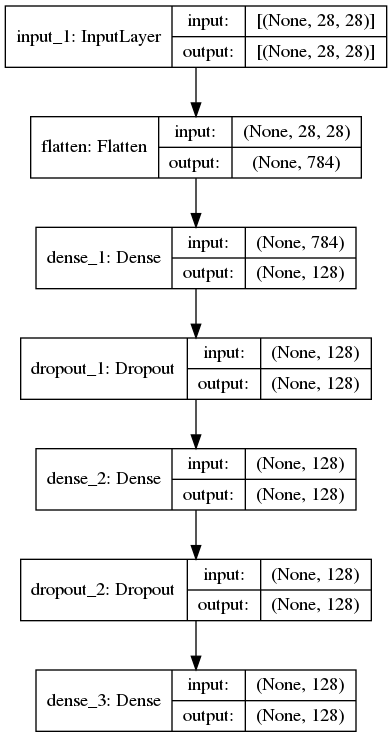

In [10]:
base_network = create_base_model()
plot_model(base_network, to_file="siamese_net_base.png", show_shapes=True, show_layer_names=True)

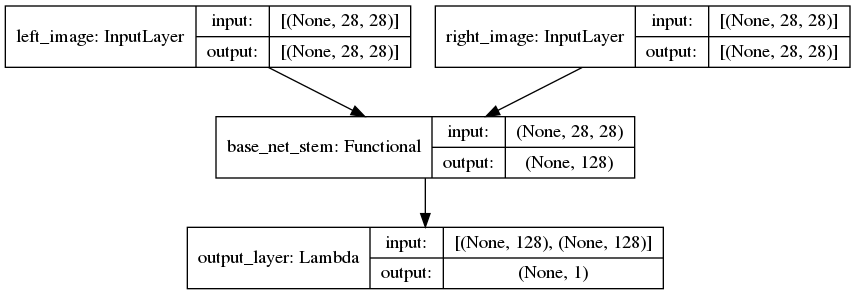

In [11]:
use_debugger = True

input_left = Input(shape=(28, 28), name="left_image")
vector_output1 = base_network(input_left)

input_right = Input(shape=(28, 28), name="right_image")
vector_output2 = base_network(input_right)

#the output is the distance between the image pair vectors
output = Lambda(euclidean_distance, name="output_layer",
                output_shape=euclidean_dist_output_shape)([vector_output1, vector_output2])

model = Model(inputs=[input_left, input_right], outputs=output)

plot_model(model , to_file="multi_input_main_model.png", show_shapes=True,
           show_layer_names=True)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
right_image (InputLayer)        [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
base_net_stem (Functional)      (None, 128)          133504      left_image[0][0]                 
                                                                 right_image[0][0]                
__________________________________________________________________________________________________
output_layer (Lambda)           (None, 1)            0           base_net_stem[0][0]          

In [13]:
def constructive_loss_with_margin(margin):
    
    def constructive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    
    return constructive_loss
        

In [15]:
model.compile(optimizer="rmsprop", loss=constructive_loss_with_margin(1))

In [19]:
tf.config.list_physical_devices()
history = model.fit([train_pairs[: , 0] , train_pairs[: , 1]] , train_labels , 
    epochs=20,
    validation_data=([test_pairs[:,0] , test_pairs[:,1]] , test_labels)
)

Epoch 1/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0826 - val_loss: 0.0768
Epoch 2/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0755 - val_loss: 0.0751
Epoch 3/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0726 - val_loss: 0.0754
Epoch 4/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0707 - val_loss: 0.0700
Epoch 5/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0690 - val_loss: 0.0713
Epoch 6/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0677 - val_loss: 0.0715
Epoch 7/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0670 - val_loss: 0.0689
Epoch 8/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0662 - val_loss: 0.0698
Epoch 9/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0657 - val_loss: 0.0699
Epoch 10/20
3750/3750 [==============================] - 11s 3ms/step - l

Text(0.5, 1.0, 'Crossentropy')

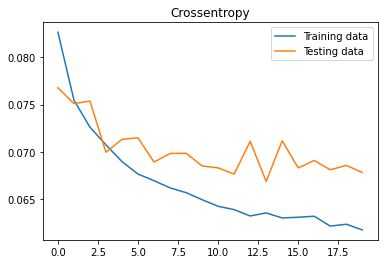

In [20]:
plt.plot(history.history['loss'] , label="Training data")
plt.plot(history.history['val_loss'] , label = "Testing data")
plt.legend()
plt.title("Crossentropy")

In [21]:
model.evaluate([test_pairs[:,0] , test_pairs[:,1]] , test_labels)

625/625 [==============================] - 1s 1ms/step - loss: 0.0678


0.06784136593341827

In [23]:
def accurecy(y_true , y_pred):
    p = y_pred.ravel() < 0.5
    return np.mean(p == y_true)

y_pred = model.predict([test_pairs[:,0] , test_pairs[:,1]])

print("Accurecy is : ",accurecy(test_labels , y_pred))

Accurecy is :  0.9092092092092092


In [24]:


pred = model.predict([test_pairs[:8 , 0] , test_pairs[:8 , 1]])
pred_ = np.where(pred < 0.5 , 1 ,0).ravel()
print("Prediction : ",pred_.astype('float32'))
print("True       : ",test_labels[:8])



Prediction :  [1. 0. 1. 0. 1. 0. 1. 0.]
True       :  [1. 0. 1. 0. 1. 0. 1. 0.]


In [ ]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
